<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/introducing_BN_Dropout_into_CNNmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用デバイス: cuda
=== データ読み込み ===


100%|██████████| 170M/170M [00:02<00:00, 63.0MB/s]


訓練データ数: 50000
テストデータ数: 10000
クラス数: 10

=== 両モデルのパラメータ数の比較 ===
基本モデル パラメータ数: 1,147,466
改良モデル パラメータ数: 3,378,634
増加率: 2.94倍

=== BasicCNN の学習 ===
[1/15] - Train Loss: 1.5300, Train Acc: 43.99%, Test Loss: 1.1486, Test Acc: 58.67%
[2/15] - Train Loss: 1.1501, Train Acc: 58.78%, Test Loss: 0.9876, Test Acc: 64.56%
[3/15] - Train Loss: 0.9782, Train Acc: 65.42%, Test Loss: 0.8206, Test Acc: 71.18%
[4/15] - Train Loss: 0.8674, Train Acc: 69.28%, Test Loss: 0.8263, Test Acc: 71.63%
[5/15] - Train Loss: 0.7935, Train Acc: 72.09%, Test Loss: 0.7129, Test Acc: 75.87%
[6/15] - Train Loss: 0.7375, Train Acc: 74.12%, Test Loss: 0.7163, Test Acc: 75.43%
[7/15] - Train Loss: 0.7018, Train Acc: 75.22%, Test Loss: 0.6694, Test Acc: 76.90%
[8/15] - Train Loss: 0.5851, Train Acc: 79.56%, Test Loss: 0.6015, Test Acc: 79.25%
[9/15] - Train Loss: 0.5601, Train Acc: 80.37%, Test Loss: 0.5945, Test Acc: 79.78%
[10/15] - Train Loss: 0.5502, Train Acc: 80.73%, Test Loss: 0.5825, Test Acc: 79.77%
[11/15] - Train 

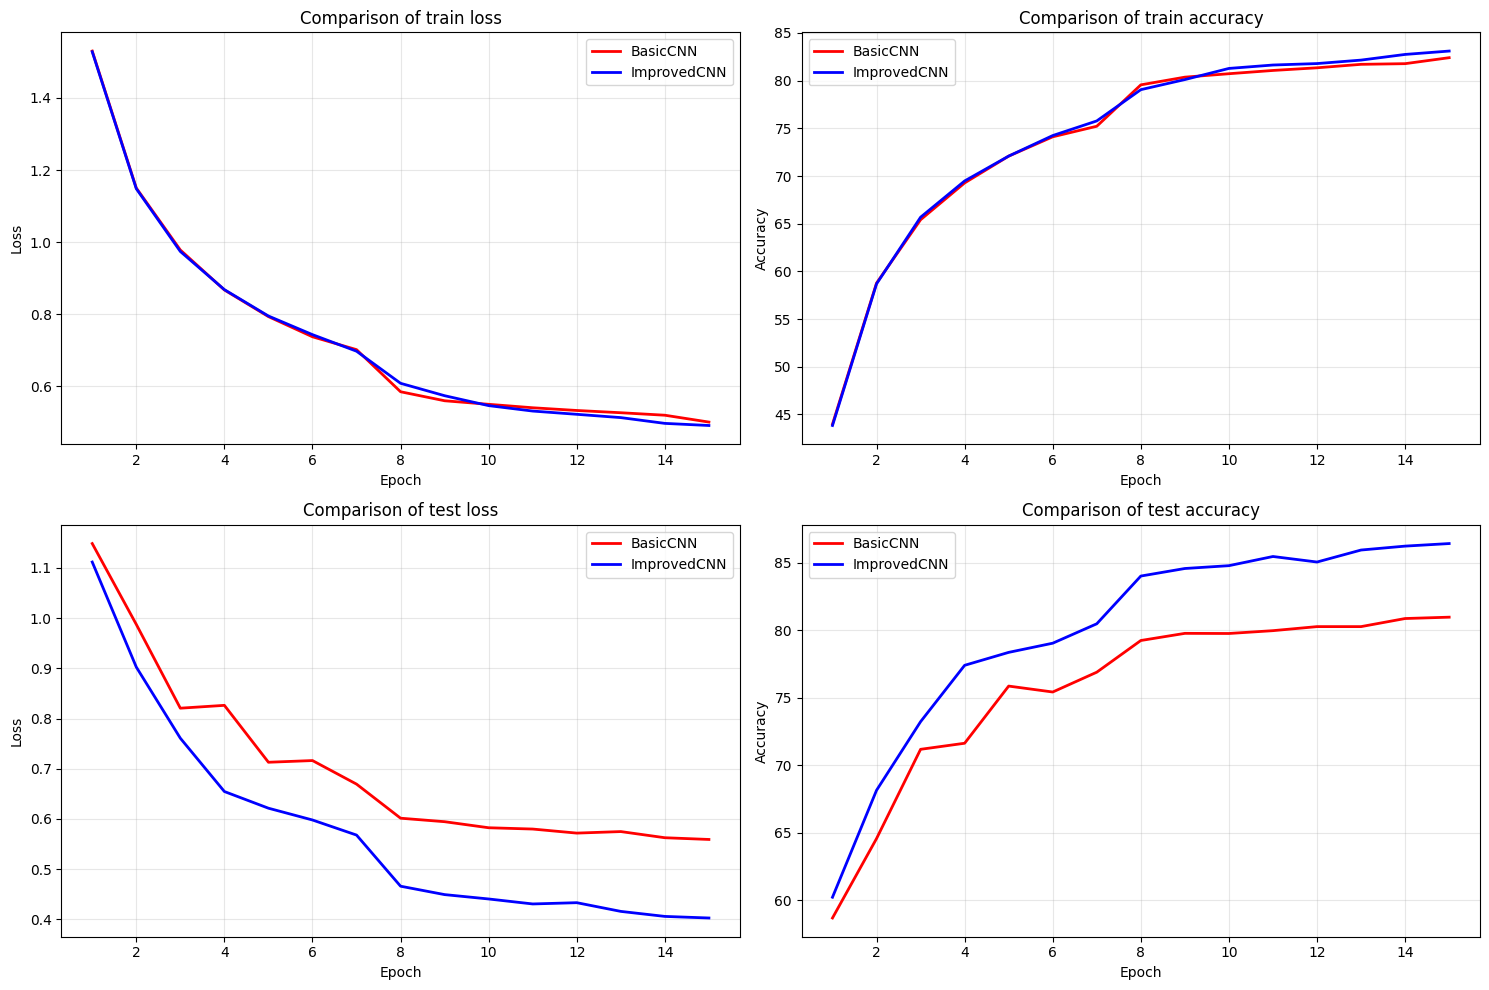

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用デバイス: {device}')

# 基本版の CNN
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()

        # 特徴抽出部
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # 分類部
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 改良版のCNN
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(ImprovedCNN, self).__init__()

        # 特徴抽出部
        self.features = nn.Sequential(
            # ブロック1: 32×32×3 → 32×32×64
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # → 16×16×64
            nn.Dropout2d(dropout_rate * 0.5),  # 畳み込み層用ドロップアウト

            # ブロック2: 16×16×64 → 16×16×128
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # → 8×8×128
            nn.Dropout2d(dropout_rate * 0.7),

            # ブロック3: 8×8×128 → 8×8×256
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # → 4×4×256
            nn.Dropout2d(dropout_rate),
        )

        # 分類部
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# CIFAR-10データセットの準備
def prepare_data():
    # データ前処理
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # データセットの読み込み
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    # CIFAR-10のクラス名
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    print(f'訓練データ数: {len(trainset)}')
    print(f'テストデータ数: {len(testset)}')
    print(f'クラス数: {len(classes)}')

    return trainloader, testloader, classes

# 学習関数
def train_model(model, trainloader, testloader, num_epochs=20, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # 学習履歴を保存するリスト
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # エポック終了時の訓練精度
        train_acc = 100. * correct / total
        train_loss = running_loss / len(trainloader)

        # テストフェーズ
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_acc = 100. * correct / total
        test_loss = test_loss / len(testloader)

        # 学習率の更新
        scheduler.step()

        # 履歴に追加
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'[{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    total_time = time.time() - start_time
    print(f'学習に要した時間: {total_time:.2f}秒')

    return train_losses, train_accuracies, test_losses, test_accuracies

# 学習曲線の描画
def plot_learning_curves(basic_history, improved_history, num_epochs):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, num_epochs + 1)

    # 訓練損失
    axes[0, 0].plot(epochs, basic_history[0], 'r-', label='BasicCNN', linewidth=2)
    axes[0, 0].plot(epochs, improved_history[0], 'b-', label='ImprovedCNN', linewidth=2)
    axes[0, 0].set_title('Comparison of train loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 訓練精度
    axes[0, 1].plot(epochs, basic_history[1], 'r-', label='BasicCNN', linewidth=2)
    axes[0, 1].plot(epochs, improved_history[1], 'b-', label='ImprovedCNN', linewidth=2)
    axes[0, 1].set_title('Comparison of train accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # テスト損失
    axes[1, 0].plot(epochs, basic_history[2], 'r-', label='BasicCNN', linewidth=2)
    axes[1, 0].plot(epochs, improved_history[2], 'b-', label='ImprovedCNN', linewidth=2)
    axes[1, 0].set_title('Comparison of test loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # テスト精度
    axes[1, 1].plot(epochs, basic_history[3], 'r-', label='BasicCNN', linewidth=2)
    axes[1, 1].plot(epochs, improved_history[3], 'b-', label='ImprovedCNN', linewidth=2)
    axes[1, 1].set_title('Comparison of test accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# モデル比較実験
def compare_models():
    # データ準備
    print("=== データ読み込み ===")
    trainloader, testloader, classes = prepare_data()

    # モデル初期化
    basic_model = BasicCNN()
    improved_model = ImprovedCNN()

    # パラメータ数比較
    basic_params = sum(p.numel() for p in basic_model.parameters())
    improved_params = sum(p.numel() for p in improved_model.parameters())

    print("\n=== 両モデルのパラメータ数の比較 ===")
    print(f"基本モデル パラメータ数: {basic_params:,}")
    print(f"改良モデル パラメータ数: {improved_params:,}")

    # 学習設定
    num_epochs = 15  # 実験のため少なめに設定

    print("\n=== BasicCNN の学習 ===")
    basic_history = train_model(basic_model, trainloader, testloader, num_epochs)

    print("\n=== ImprovedCNN の学習 ===")
    improved_history = train_model(improved_model, trainloader, testloader, num_epochs)

    # 結果比較
    print("\n=== 学習後の性能比較 ===")
    print(f"BasicCNN:        test accuracy: {basic_history[3][-1]:.2f}%")
    print(f"ImprovedCNN: test accuracy: {improved_history[3][-1]:.2f}%")

    # 学習曲線の描画
    plot_learning_curves(basic_history, improved_history, num_epochs)

    return basic_model, improved_model, basic_history, improved_history

# 実行
if __name__ == "__main__":
    basic_model, improved_model, basic_history, improved_history = compare_models()